In [2]:
import wrf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import xarray as xr
import netCDF4 as nc
import numpy as np
import math
import cartopy.crs as ccrs

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

In [3]:
def uv(df):
    
        df["u"] = [-ws * math.sin(math.radians(wd)) for ws, wd in zip(df["ws"].values, df["wd"].values)]
        df["v"] = [-ws * math.cos(math.radians(wd)) for ws, wd in zip(df["ws"].values, df["wd"].values)]        
        
        return df

def load_obs(time):
    
    #Load upper air sounding for sydney airport
    
    names = ["record_id","stn_id","date_time","ta","ta_quality","dp","dp_quality",\
            "rh","rh_quality","ws","ws_quality","wd","wd_quality","p","p_quality",
            "z","z_quality","symbol"]

    ua = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/upper_air/UA01D_Data_066037_999999999723955.txt",header=None,names=names)
    ua["date_time"] = pd.to_datetime(ua["date_time"],format="%d/%m/%Y %H:%M")
    ua = ua.set_index("date_time").loc[time]
    
    for c in ["ta","dp","rh","ws","wd","p","z"]:
        ua[c] = pd.to_numeric(ua[c],errors="coerce")
    
    return uv(ua).dropna()

def load_sonde(f):

    #Load radiosonde data from disk
    names = ["Elapsed time","HeightMSL","P","Temp","RH","Dewp","Dir","Speed","GpsHeightMSL","AscRate","Pc","Lat","Lon","VirT","PotTemp","KeyFlags"]
    df = pd.read_csv(f,skiprows=55,encoding='cp1252',names=names,index_col="Elapsed time")
    meta = pd.read_table(f,nrows=51,skiprows=0,encoding='cp1252')
    meta = meta.set_index(np.array([i.strip() for i in meta.index]))
    
    #Extract numpy arrays from the dataframe. Assign units and plot using metpy
    p = df['P'].values * units.hPa
    T = df['Temp'].values * units.degC
    Td = df['Dewp'].values * units.degC
    z = df["HeightMSL"].values * units.meter
    uwin, vwin = mpcalc.wind_components(df["Speed"].values * units('m/s'), df["Dir"].values * units.deg)

    return df, meta, p, T, Td, z, uwin, vwin    

def extract_wrf_all(wrfout, tc, hgt, p, td, u, v, lat=-33.9500, lon=151.1817):
    
    x_y = wrf.ll_to_xy(wrfout,lat,lon)
    x = int(x_y.sel(x_y="x").values)
    y = int(x_y.sel(x_y="y").values)    
    
    #Take wrf grids and output arrays with units
    p_out = p.sel(west_east=x,south_north=y).values/100 * units.hectopascal
    tc_out = tc.sel(west_east=x,south_north=y).values * units.degree_Celsius
    td_out = td.sel(west_east=x,south_north=y).values * units.degree_Celsius    
    hgt_out = hgt.sel(west_east=x,south_north=y).values * units.meter
    u_out = u.sel(west_east=x,south_north=y).values * units.meter_per_second
    v_out = v.sel(west_east=x,south_north=y).values * units.meter_per_second
    
    return p_out, tc_out, td_out, hgt_out, u_out, v_out, p.sel(west_east=x,south_north=y)["XLONG"].values, p.sel(west_east=x,south_north=y)["XLAT"].values

def extract_wrf_logspace(wrfout, tc, hgt, p, td, u, v, lat=-33.9500, lon=151.1817):
    
    x_y = wrf.ll_to_xy(wrfout,lat,lon)
    x = int(x_y.sel(x_y="x").values)
    y = int(x_y.sel(x_y="y").values)    
    
    xp = np.flip(p.sel(west_east=x,south_north=y).values)
    yp = np.flip(p.bottom_top.values)
    xi = np.logspace(3,2,20) * 100

    pind = np.interp(xi,xp,yp).round().astype(int)    
    
    #Take wrf grids and output arrays with units, but with log spacing in vertical (for nice wind barb spacing)
    p_out = p.sel(west_east=x,south_north=y,bottom_top=pind).values/100 * units.hectopascal
    tc_out = tc.sel(west_east=x,south_north=y,bottom_top=pind).values * units.degree_Celsius
    td_out = td.sel(west_east=x,south_north=y,bottom_top=pind).values * units.degree_Celsius    
    hgt_out = hgt.sel(west_east=x,south_north=y,bottom_top=pind).values * units.meter
    u_out = u.sel(west_east=x,south_north=y,bottom_top=pind).values * units.meter_per_second
    v_out = v.sel(west_east=x,south_north=y,bottom_top=pind).values * units.meter_per_second
    
    return p_out, tc_out, td_out, hgt_out, u_out, v_out

def get_pcl(pres, hght, tmpc, dwpc, u, v, flag):
    
    prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, u=u*1.94384, v=v*1.94384, missing=-9999, strictQC=False)
    
    return params.parcelx( prof, flag=flag ), prof

def calc_params(pres, hght, tmpc, dwpc, u, v, lfc_hght):

    """
    Calculate various sounding diagnostics and return as a text object to display on skewt
    """

    import sharppy.sharptab.profile as profile
    import sharppy.sharptab.params as params
    import sharppy.sharptab.interp as interp
    import sharppy.sharptab.winds as winds
    import sharppy.sharptab.utils as utils
    
    prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, u=u*1.94384, v=v*1.94384, strictQC=False)
    
    sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
    mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
    mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
    
    sfc = prof.pres[prof.sfc]
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))    
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))    
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))    
    mean_6km = winds.mean_wind(prof, pbot=sfc, ptop=p6km)
    s06 = winds.wind_shear(prof,pbot=sfc,ptop=p6km)
    
    parcel_disp = sfcpcl
    parcel_text = "Surface-based"
    text_disp = \
        parcel_text+" CAPE: " + str(np.round(parcel_disp.bplus,1)) + " J/kg\n" +\
        parcel_text+" LCL: " + str(np.round(parcel_disp.lclhght,1)) + " m\n" +\
        "0-6 km Mean Wind (m/s): " + str((utils.comp2vec(mean_6km[0], mean_6km[1])[1]/1.94384).round(1)) + " m/s\n" +\
        "Qmean01: " + str(params.mean_mixratio(prof,pbot=sfc,ptop=p1km).round(1)) +" g/kg\n"+\
        "LR13: " + str(params.lapse_rate(prof,p1km,p3km).round(1))+" C/km\n" +\
        "S06: " + str((utils.comp2vec(s06[0],s06[1])[1]/1.94384).round(1))+" m/s"# +\
        #"Surface T: "+str(tmpc[0].round(1))+" degC\n"+\
        #"Surface Td: "+str(dwpc[0].round(1))+" degC"
        #parcel_text+" CIN: " + str(np.round(parcel_disp.bminus,1)) + " J/kg\n" +\
        #parcel_text+" LFC: " + str(np.round(interp.hght(prof,np.array(lfc_hght[0])),1)) + " m\n" +\
        #"Most-unstable CAPE: " + str(np.round(mupcl.bplus,1)) + " J/kg\n" +\
        #"DCAPE: " + str(params.dcape(prof)[0].round(1)) + " J/kg\n" +\
    
    return text_disp

def plot_skewT_wrf(fig, index, nrows, ncols, tc, hgt, p, plog, td, u, ulog, v, vlog, title=""):

    #Virtual temp
    tv = mpcalc.virtual_temperature_from_dewpoint(p, tc, td)
    
    # Grid for plots
    skew = SkewT(fig, rotation=45, subplot=(nrows, ncols, index))

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot

    skew.plot(p, tc, 'r', lw=2)
    skew.plot(p, tv, 'r', ls=":", lw=2)    
    skew.plot(p, td, 'g')
    skew.plot_barbs(plog,ulog,vlog,plot_units=units.meter_per_second,xloc=1.075)
    skew.ax.set_ylim(1050, 100)

    # Add the relevant special lines
    # skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    
    #Labels
    plt.xlabel("Temperature (degrees C)")
    plt.ylabel("Pressure (hPa)")
    plt.title(title)
    lfchght = mpcalc.lfc(p,tc,td,which="most_cape")
    plt.text(-45, 650, calc_params(np.array(p), np.array(hgt), np.array(tc), np.array(td), np.array(u), np.array(v), lfchght),
        va="top",ha="left",bbox={"ec":"k","fc":"white"},fontsize="x-small")
    

    # Calculate full parcel profile using Sharppy and add to plot as black line. Note this uses a virtual temperature correction
    pcl, prof = get_pcl(np.array(p), np.array(hgt), np.array(tc), np.array(td), np.array(u), np.array(v), flag=3)
    skew.plot(pcl.ptrace, pcl.ttrace, 'k-.', lw=2)    

    # Shade areas of CAPE and CIN
    # skew.shade_cape(p,tc, prof)

    # Good bounds for aspect ratio
    skew.ax.set_xlim(-30, 30)

    # Create a hodograph
    #inds = (p>(100*units.hectopascal))
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    h = Hodograph(ax_hod, component_range=50.)
    h.add_grid(increment=10)
    h.plot_colormapped(u,v,hgt,intervals=[0,3000,6000,9000,12000],colors=["r","g","b","k"],lw=2)
    plt.xlabel("U (m/s)")
    plt.ylabel("V (m/s)")    
    
    return pcl, prof

def load_wrf(fname,lat,lon):
    wrfout = nc.Dataset(fname)
    
    #Extract relevant variables using wrf-python
    tc_wrf = wrf.getvar(wrfout,"tc")   #Celcius
    hgt_wrf = wrf.destagger((wrf.getvar(wrfout,"PH",timeidx=0) + wrf.getvar(wrfout,"PHB",timeidx=0)) / 9.8, 0, meta=True)   #m
    p_wrf = wrf.getvar(wrfout,"p")     #Pa
    td_wrf = wrf.getvar(wrfout,"td")   #Celcius
    u_wrf = wrf.getvar(wrfout,"ua")    #m/s
    v_wrf = wrf.getvar(wrfout,"va")    #m/s
    
    #Extract profiles nearest to Sydney airport
    p_wrf_arr, tc_wrf_arr, td_wrf_arr, hgt_wrf_arr, u_wrf_arr, v_wrf_arr, wrf_lon, wrf_lat = extract_wrf_all(wrfout, tc_wrf, hgt_wrf, p_wrf, td_wrf, u_wrf, v_wrf, lat=lat, lon=lon)
    #Extract profiles but decrease spacing to log-p for nice wind barb spacing
    p_wrf_logarr, tc_wrf_logarr, td_wrf_logarr, hgt_wrf_logarr, u_wrf_logarr, v_wrf_logarr = extract_wrf_logspace(wrfout, tc_wrf, hgt_wrf, p_wrf, td_wrf, u_wrf, v_wrf, lat=lat, lon=lon)    
    
    return tc_wrf_arr, hgt_wrf_arr, p_wrf_arr, p_wrf_logarr, td_wrf_arr, u_wrf_arr, u_wrf_logarr, v_wrf_arr, v_wrf_logarr, wrf_lon, wrf_lat

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


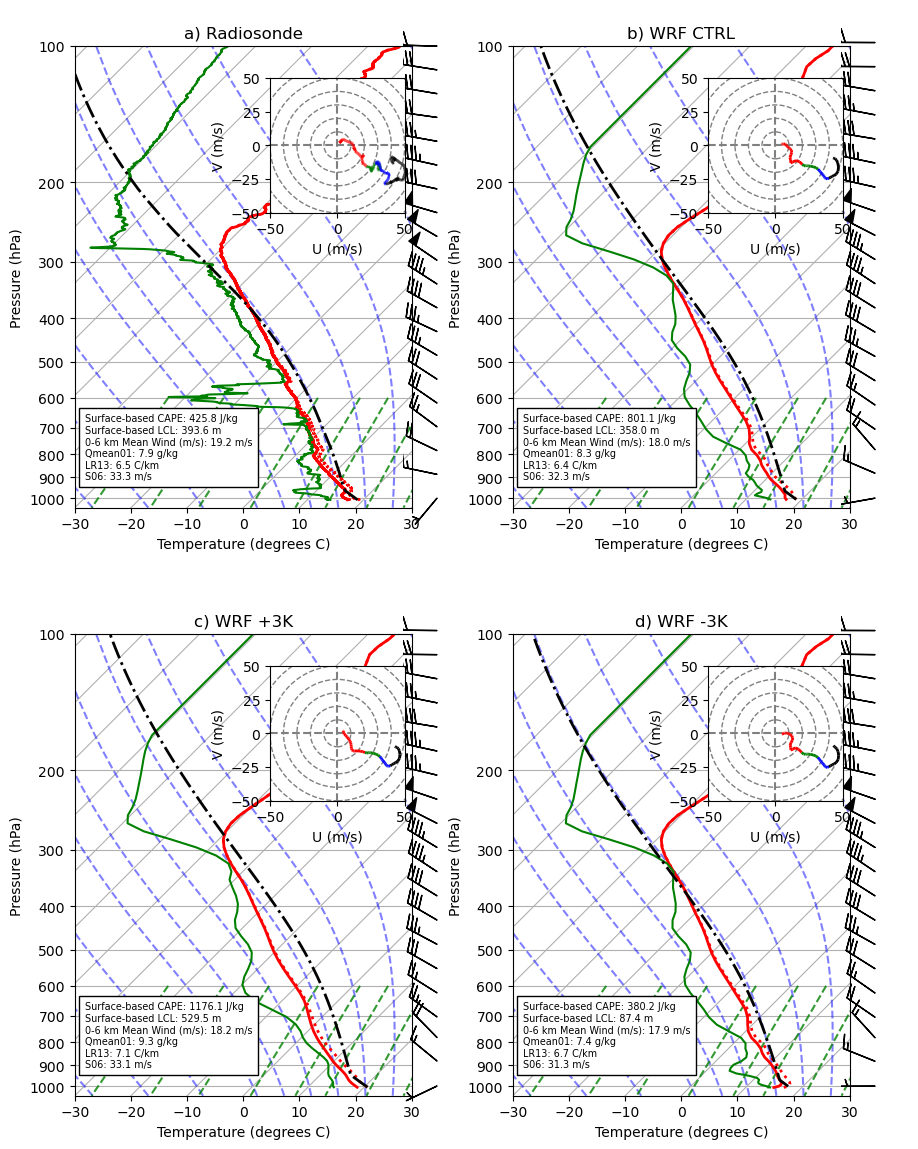

In [5]:
#Plot skewT with hodograph and convective diagnostics

#Load obs
df,meta,p_obs_arr,tc_obs_arr,td_obs_arr,hgt_obs_arr,u_obs_arr,v_obs_arr=load_sonde("/g/data/w40/ab4502/IN2023_V06/data/sondes/Radiosonde/VLMJ_YMC_RS41_isf_20231015_230328.txt")

#Get log spacing for p, u and v
xp = np.flip(df["P"]).values
yp = np.flip(np.arange(df.shape[0]))
xi = np.logspace(3,2,20)
pind = np.interp(xi,xp,yp).round().astype(int) 
p_obs_logarr = p_obs_arr[pind]
u_obs_logarr = u_obs_arr[pind]
v_obs_logarr = v_obs_arr[pind]

#Load the WRF netcdf output from disk

fname = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d01_2023-10-15_23:00:00"
tc_wrf_arr, hgt_wrf_arr, p_wrf_arr, p_wrf_logarr, td_wrf_arr, u_wrf_arr, u_wrf_logarr, v_wrf_arr, v_wrf_logarr, wrf_lon, wrf_lat =\
    load_wrf(fname,df["Lat"][0],df["Lon"][0])
fname = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/highres_d01_2023-10-15_23:00:00"
tc_wrf3p_arr, hgt_wrf3p_arr, p_wrf3p_arr, p_wrf3p_logarr, td_wrf3p_arr, u_wrf3p_arr, u_wrf3p_logarr, v_wrf3p_arr, v_wrf3p_logarr, wrf3p_lon, wrf3p_lat =\
    load_wrf(fname,df["Lat"][0],df["Lon"][0])
fname = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/highres_d01_2023-10-15_23:00:00"
tc_wrf3m_arr, hgt_wrf3m_arr, p_wrf3m_arr, p_wrf3m_logarr, td_wrf3m_arr, u_wrf3m_arr, u_wrf3m_logarr, v_wrf3m_arr, v_wrf3m_logarr, wrf3m_lon, wrf3m_lat =\
    load_wrf(fname,df["Lat"][0],df["Lon"][0])

fig = plt.figure(figsize=(10, 14))
wrf_pcl, wrf_prof = plot_skewT_wrf(fig, 4, 2, 2, 
                                   tc_wrf3m_arr, hgt_wrf3m_arr, p_wrf3m_arr, p_wrf3m_logarr, td_wrf3m_arr, u_wrf3m_arr, u_wrf3m_logarr, v_wrf3m_arr, v_wrf3m_logarr,
                                   title="d) WRF -3K")
wrf_pcl, wrf_prof = plot_skewT_wrf(fig, 3, 2, 2, 
                                   tc_wrf3p_arr, hgt_wrf3p_arr, p_wrf3p_arr, p_wrf3p_logarr, td_wrf3p_arr, u_wrf3p_arr, u_wrf3p_logarr, v_wrf3p_arr, v_wrf3p_logarr,
                                   title="c) WRF +3K")
wrf_pcl, wrf_prof = plot_skewT_wrf(fig, 2, 2, 2,
                                   tc_wrf_arr, hgt_wrf_arr, p_wrf_arr, p_wrf_logarr, td_wrf_arr, u_wrf_arr, u_wrf_logarr, v_wrf_arr, v_wrf_logarr,
                                   title="b) WRF CTRL")
obs_pcl, obs_prof = plot_skewT_wrf(fig, 1, 2, 2,
                                   tc_obs_arr, hgt_obs_arr, p_obs_arr, p_obs_logarr, td_obs_arr, u_obs_arr, u_obs_logarr, v_obs_arr, v_obs_logarr,
                                   title="a) Radiosonde")
plt.subplots_adjust(wspace=0.3)
#plt.suptitle("2023-10-15 23:00 UTC",fontsize=18,fontweight="bold",)

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/soundings.jpeg",dpi=400,bbox_inches="tight")